# EE5175 Lab 5 : Space-variant Blurring
### Author : Niyas Mon P
### Roll No: EE20B094


<!-- #### Input : Mandrill.png
#### Task  : Perform a 2D convolution with a gaussian filter given a $\sigma$.
#### Output : blurred image -->

In [156]:
#  Before running the code blocks, please ensure all the images are uploaded

In [157]:
# importing necessary libraries
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [158]:
globe = cv2.imread('Globe.png')
nautilus = cv2.imread('Nautilus.png')

In [159]:
# convert image from 3 channel to 1 channel image. cause, it is in gray scale
globe = globe[:,:,0]
nautilus = nautilus[:,:,0]

## Gaussian filter
* We are assuming the Point Spread Function(PSF) is Gaussian
* The spread is determined by the value of $\sigma$.
\begin{align*}
h(n,m) = \frac{1}{2\pi\sigma^2} e ^{-\frac{(n^2 + m^2 )}{2 \sigma^2}}
\end{align*}
* Ideally the Gaussian PSF spreads to infinity. But due to limitation we are trunking the spread function to $\pm3\sigma$ from the centre where $99\%$ of gaussian spread exists. Hence our kernel size is odd number nearest to $⌈6\sigma + 1 ⌉$. Odd number is taken inorder have a well defined centre.
* Since the PSF exists for finite region, we are normalizing the values of the kernel so that the kernel values add up to 1.

In [160]:
# gaussian filter
def gaussian_filter(sigma):

  # if sigma is zero, kernel size is 1 with value 1
  if sigma == 0:
    return np.ones((1,1))

  # kernel size is odd number equal to or next nearest to (6*sigma +1)
  size            = int(np.ceil(6*sigma + 1))
  size            = size if (size % 2 == 1) else size + 1
  # initializing a blank kernel
  kernel          = np.zeros((size,size))

  # updating the kernel with gaussian values where (0,0) being at the centre
  for n in range(size):
    for m in range(size):
      i           = n - size//2
      j           = m - size//2
      kernel[n,m] = np.exp(-(i**2 + j**2)/(2*sigma**2))

  # normalizing the kernel so that sum = 1
  sum             = np.sum(kernel,axis=None)
  kernel          = (kernel / sum )

  return kernel

### Zero padding
* Zero padding is needed around the image inorder to perform the 2D convolution operation. And number of pixels padded on one side will be '$n$' if kernel size is '$2n+1$'.
* The padding is done inorder to make sure that when convolution of peripheral pixels are done with kernel, the the kernel values sitting outside the image are getting multiplied with zero.

In [161]:
# return a zero padded image required for convolution
def pad(image,kernel_size):

  # kernel_size = kernel.shape[0]
  # no of zero padding on one side will be 'n' if kernel size is '2n+1'
  pad_size    = kernel_size//2
  # dimensions of original image
  ht, wd      = image.shape

  # if the kernel size is 1, the no need for padding
  if kernel_size == 1:
    return image

  # zero padding
  padded_image = np.zeros((ht+ 2*pad_size,wd+ 2*pad_size))
  padded_image[pad_size:-pad_size,pad_size:-pad_size] = image

  return padded_image

## 2D convolution (Space Invariant Blur)
#### Following function takes the image and the kernel as the inputs and outputs the convolved image.

In [162]:
# 2D convolution with kernel :-> Space Invariant Blur
def blur(image,kernel):

  # abstracting image size and kernel size
  img_ht , img_wd = image.shape
  kernel_size     = kernel.shape[0]

  # if kernel size is 1, then output will be the image multiplied by the kernel value
  if kernel_size == 1:
    return image * kernel[0,0]

  # zero padding
  padded_image    = pad(image,kernel_size)
  # creating a blank image for output
  blurred_image    = np.zeros_like(image)

  for n in range(img_ht):
    for m in range(img_wd):
      # 2D convolution with kernal
      conv2d_val        = np.sum(padded_image[n:n+kernel_size,m:m+kernel_size] * kernel, axis=None)
      blurred_image[n,m] = conv2d_val

  return blurred_image


## **Space Variant Blurring**

## Calculating sigma values at each pixel
Now the blur is space variant. The standard deviation at each pixel is given by the following distribution
$$
\sigma(m,n) = Aexp\frac{-((m-\frac{N}{2})^2+(n-\frac{N}{2})^2)}{B}, \quad 0\leq m,n \leq N-1
$$
where the image is of the size $N\times N$.

We need to find the values of A and B from the 2 conditions given.
$$
\begin{align*}
\sigma(\frac{N}{2},\frac{N}{2}) &= 2.0 \\ \\
\sigma(0,0) &= 0.01
\end{align*}
$$

On Solving,
$$
\begin{align*}
A &= 2.0, \\\\
B &= \frac{N^{2}}{2log_{e}(200)}
\end{align*}
$$

### The following function returns the $\sigma$-array, given the size of image

In [163]:
def calculate_sigma(size,const_sigma=False):
  N = size   # size of the image. Image is of  N x N size

  # values of A and B
  A = 2.0
  B = (N**2)/(2*np.log(200))

  # Creating blank array for storing Sigma values of each pixel
  sigma_array = np.zeros((N,N))

  for i in range(N):
    for j in range(N):

      if const_sigma:  # if σ(m,n) = 1.0 for all m,n
        sigma_array[i,j] = 1.0
      else:  # distribution of σ(m,n)
        sigma_array[i,j] = A*np.exp((-(i-N/2.0)**2 - (j-N/2.0)**2) / B )
  return sigma_array

### Performing space variant blurring
* For each pixel we compute the kernel.
* Multiply the kernel with the intensity of that pixel
* Add this subarray to the output canva.

In [164]:
def space_variant_blur(image,const_sigma=False):

  # abstracting image size
  size = image.shape[0]

  # calculating the σ(m,n) array
  sigma_array = calculate_sigma(size,const_sigma)

  # zero padding
  max_kernel_size = int(np.ceil(6*np.max(sigma_array) + 1))
  max_kernel_size = max_kernel_size if (max_kernel_size % 2 == 1) else max_kernel_size + 1
  # pad size depends on maximum kernel size possible
  padded_image    = pad(image,max_kernel_size)
  pad_size        = max_kernel_size//2

  # creating a blank image for output
  blurred_image    = np.zeros_like(padded_image)


  for n in range(size):
    for m in range(size):
      # computing the kernel for the specific pixel
      kernel = gaussian_filter(sigma_array[n,m])

      kernel_size = kernel.shape[0]
      w = kernel_size//2
      # multiply the kernel with the intensity of the pixel and adding them to the canvas
      blurred_image[n+pad_size-w:n+pad_size+w+1,m+pad_size-w:m+pad_size+w+1]      += kernel * image[n,m]

  # return the blurred image after cropping the padded part
  return blurred_image[pad_size:-pad_size,pad_size:-pad_size]

### Gaussian blurring on 'Globe.png'

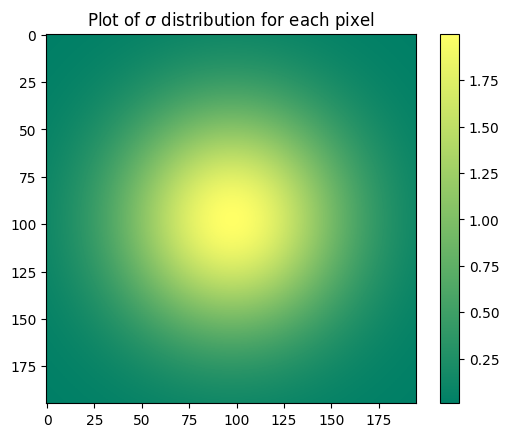

In [165]:
# plotting the sigma array
N = globe.shape[0]
plt.imshow(calculate_sigma(N),cmap='summer')
plt.title("Plot of $\sigma$ distribution for each pixel")
plt.colorbar()
plt.show()

#### From the above plot, we see that the maximum standard deviation occure at the middle part. Hence we expect the middle of the image will be more blurred and the blur decreases away from the centre.

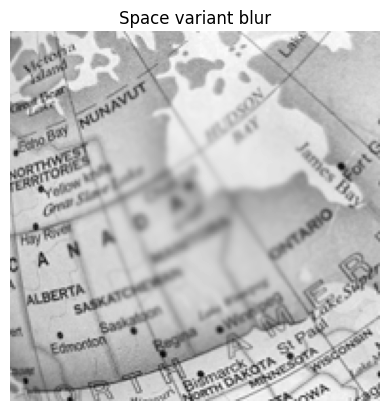

In [166]:
# space variant blur of 'globe.png'
space_variant_blurred_image = space_variant_blur(globe)

plt.imshow(space_variant_blurred_image,cmap='gray')
plt.title("Space variant blur")
plt.axis('off')
plt.show()

#### As we expected, the blur is more in the middle and decreases away from the centre.

## Blurring of 'Nautilus.png'

### (a) space-invariant blur of 'Nautilus.png' with σ = 1.0

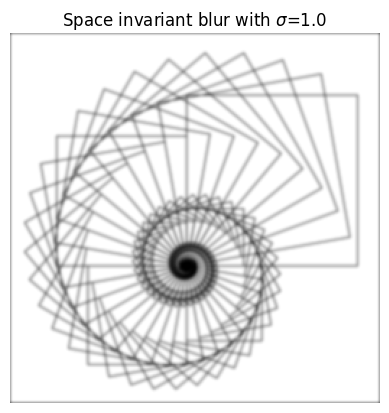

In [167]:
# space-invariant blur of 'Nautilus.png' with σ = 1.0
sigma = 1.0
kernel       = gaussian_filter(sigma)
space_invariant_nautilus_blur = blur(nautilus,kernel)

plt.title(f'Space invariant blur with $\sigma$={sigma}')
plt.imshow(space_invariant_nautilus_blur,cmap='gray')
plt.axis('off')
plt.show()

### (b) space-variant blur  with σ(m, n) = 1.0 for 0 ≤ m, n ≤ N − 1

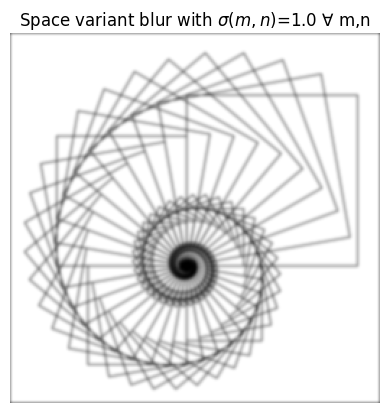

In [168]:
# space-variant blur of 'Nautilus.png' with σ(m, n) = 1.0 for 0 ≤ m, n ≤ N − 1
# put 'const_sigma' argument value as 'True' inorder to make all sigma values as 1.0
space_variant_nautilus_blur = space_variant_blur(nautilus,const_sigma=True)

plt.imshow(space_variant_nautilus_blur,cmap='gray')
plt.title(f'Space variant blur with $\sigma(m,n)$={sigma} \u2200 m,n')
plt.axis('off')
plt.show()

### Inorder to show that the 2 blurred images using (a) and (b) are the same, let's take the difference of the 2 images

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


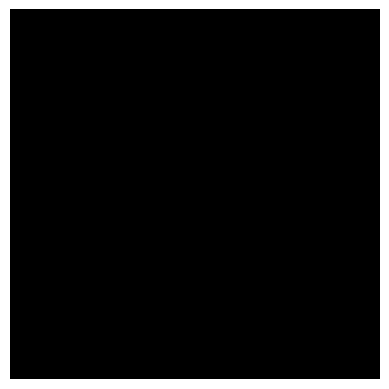

In [169]:
# Taking the absolute difference between the 2 images
diff = np.abs(space_variant_nautilus_blur-space_variant_nautilus_blur)
plt.imshow(diff,cmap='gray')
plt.axis('off')
print(diff)
plt.show()

#### We see that the difference is a blank image i,e all values are zero. Hence both the blurred images are same.

## Inferences

* The standard deviation of the blur is not same at each pixel location, it is given by a distribution. The sigma values are higher at the centre and reduces away from the centre. This reflects in the space variant blurred image which is more blurred in the middle portion with less blurring away from the centre.
* Space variant, hence we cannot use normal convolution method to get the output.
* Space variant blur with a constant sigma everywhere produces same result as that of the space invariant blur with the same sigma.
* Zero padding is done by using the maximum kernel size.
* The time complexity has increased by several times for space variant bluring compared to space invariant blurring because, in the former we need to compute the kernel for each pixel and in the latter kernel need to be computed only once.